In [1]:
import numpy as np
import matplotlib.pyplot as plt

from math import ceil, floor
from scipy.optimize import minimize
from tqdm import tqdm
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from clusterlensing import ClusterLensing
from astropy.cosmology import FlatLambdaCDM
import pandas as pd

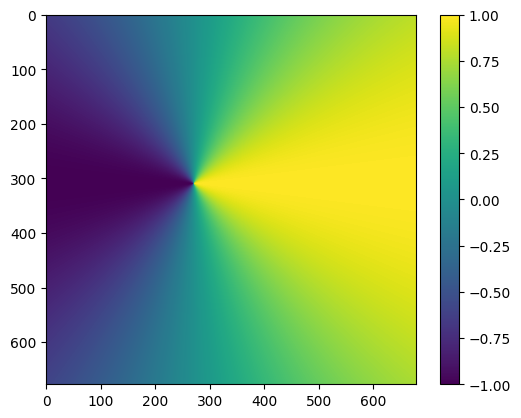

In [2]:
#checking the vaildity of the source plane map

import matplotlib.pyplot as plt
# specify the choice of lens models #
lens_model_list = ['SIS']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
theta_E = 100                 #in pixel
len_coord = (270, 310)        #in pixel
kwargs_sie = {'theta_E': theta_E, 'center_x': len_coord[0], 'center_y': len_coord[1]}
kwargs_lens = [kwargs_sie]

# image plane coordinate #
size = 678
pixscale = 0.01
x_grid, y_grid = np.meshgrid(np.linspace(0, size-1, size), np.linspace(0, size-1, size))

# Flatten the grid for calculations
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Calculate convergence (kappa)
kappa = lensModel.kappa(x_flat, y_flat, kwargs_lens)

# Reshape back to 2D grid
#kappa_2d = kappa.reshape(x_grid.shape)

# ray-tracing to the source plane

alpha_x, alpha_y = lensModel.alpha(x_flat, y_flat, kwargs_lens)
# make beta_x and beta_y 2d

alpha_x_2d = alpha_x.reshape(x_grid.shape)
alpha_y_2d = alpha_y.reshape(x_grid.shape)

psi = lensModel.potential(x_flat, y_flat, kwargs_lens)
psi = psi.reshape(x_grid.shape)
psi_arcsec = psi * pixscale**2

alpha_x_arcsec = alpha_x_2d * pixscale
alpha_y_arcsec = alpha_y_2d * pixscale

plt.imshow(alpha_x_arcsec)   #assume this is in arcsec
plt.colorbar()

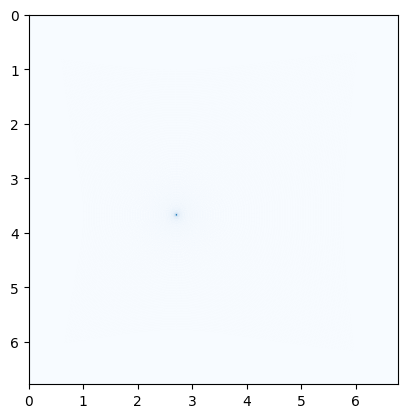

In [5]:
# illustrate the casutic
array_test = np.zeros([678,678])

for i in range(0, 678):
    for j in range(0, 678):
        ycoord = i-alpha_y_2d[i,j] # src coord
        xcoord = j-alpha_x_2d[i,j]
        if ycoord<0 or ycoord>677 or xcoord<0 or xcoord>677:
            continue
        xceil = ceil(xcoord)
        yceil = ceil(ycoord)
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        if i%3==0 and j%3==0:
            array_test[yfloor,xfloor] += 1 
      
    
plt.imshow(array_test, cmap='Blues', extent=[0, 678* pixscale, 0, 678 * pixscale])
plt.gca().invert_yaxis()

In [34]:
beta = np.array([2.14444444, 3.43333333])/pixscale #in pixel
z_s = 1.5
z_l = 0.5
cluster = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , z_s, pixscale, 678, diff_z = True)
lensModel = LensModel(lens_model_list=lens_model_list)
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
D_S1 = cosmo.angular_diameter_distance(1.0)
D_S2 = cosmo.angular_diameter_distance(z_s)
D_LS1 = cosmo.angular_diameter_distance_z1z2(z_l, 1.0)
D_LS2 = cosmo.angular_diameter_distance_z1z2(z_l, z_s)
scal = (D_LS1 * D_S2)/(D_LS2 * D_S1)
print(scal)

0.7551897621430999


In [35]:
# lenstronomy
# the class assume z_s = 1
kwargs_mp = {'theta_E': theta_E * scal * pixscale,  'center_x': len_coord[0]* pixscale, 'center_y': len_coord[1]* pixscale}
kwargs_lens = [kwargs_mp]
solver1 = LensEquationSolver(lensModel)
thetax, thetay = solver1.image_position_from_source(beta[0]* pixscale, beta[1]* pixscale, kwargs_lens)
theta_analytical = [[] for _ in range(len(thetax))]

for i in range(len(thetax)):
    theta_analytical[i] = thetax[i] , thetay[i]

theta_analytical = np.array(theta_analytical)
sorted_theta_analytical = sorted(theta_analytical, key=lambda x: x[0])  # sort by x coordinate, in arcsec now

# my class
theta_numerical = cluster.get_image_positions(beta[0]*pixscale, beta[1]*pixscale)


#plt.scatter(theta_numerical[:,0] / pixscale, theta_numerical[:,1] / pixscale, color='blue', s=5, marker='x')
#plt.scatter(thetax, thetay, color='red', s=10)
#plt.scatter(beta[0], beta[1], color='green', s=10)
#plt.imshow(array_test, cmap='Blues')
#plt.gca().invert_yaxis()
print(beta * pixscale)



for i in range(len(sorted_theta_analytical)):
    print(f'Image {i+1} position: {theta_numerical[i]}')
    print(f'Predicted Image {i+1} position: {sorted_theta_analytical[i]}')
    
    print(f'Difference: {np.sqrt((theta_numerical[i][0]-sorted_theta_analytical[i][0])**2 + (theta_numerical[i][1]-sorted_theta_analytical[i][1])**2)}')  

[2.14444444 3.43333333]
Image 1 position: (1.496878488386397, 3.8218755351269755)
Predicted Image 1 position: [1.49687456 3.82187525]
Difference: 3.94026386730046e-06


IndexError: list index out of range

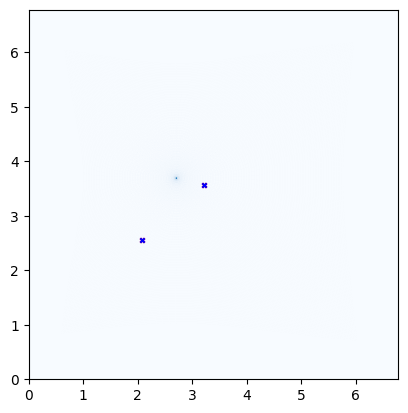

In [9]:
plt.imshow(array_test, cmap='Blues', extent=[0, 678* pixscale, 0, 678 * pixscale])
for i in range(len(sorted_theta_analytical)):
    plt.scatter(sorted_theta_analytical[i][0], sorted_theta_analytical[i][1], color='red', marker = 'x', s=10)
    plt.scatter(theta_numerical[i][0], theta_numerical[i][1], color='blue', marker = 'x', s=10)


In [59]:
from tqdm import tqdm
# Histogram of the difference
N = 10
len_coord_arcsec = (len_coord[0] * pixscale, len_coord[1] * pixscale)
x_bound = (len_coord_arcsec[0] - 1.5, len_coord_arcsec[0] + 1.5)
y_bound = (len_coord_arcsec[1] - 1.5, len_coord_arcsec[1] + 1.5)
src_x = np.linspace(x_bound[0], x_bound[1], N) # N elements along the line
src_y = np.linspace(y_bound[0], y_bound[1], N)
Diff = []

for i in tqdm(range(N)):
    for j in range(N):
        beta_N = np.array([src_x[i], src_y[j]])
        thetax, thetay = solver1.image_position_from_source(beta_N[0], beta_N[1], kwargs_lens)
        theta_analytical = [[] for _ in range(len(thetax))]

        for i in range(len(thetax)):
            theta_analytical[i] = thetax[i] , thetay[i]

        theta_analytical = np.array(theta_analytical)
        sorted_theta_analytical = sorted(theta_analytical, key=lambda x: x[0])  # sort by x coordinate, in arcsec now

        # my class
        theta_numerical = cluster.get_image_positions(beta_N[0], beta_N[1])

        for i in range(len(sorted_theta_analytical)):
            Diff.append(np.sqrt((theta_numerical[i][0]-sorted_theta_analytical[i][0])**2 + (theta_numerical[i][1]-sorted_theta_analytical[i][1])**2))  

  0%|          | 0/10 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [60]:
from multiprocessing import Pool
from tqdm import tqdm
import numpy as np

def compute_diff(beta_N):
    beta_x, beta_y = beta_N
    thetax, thetay = solver1.image_position_from_source(beta_x, beta_y, kwargs_lens)
    theta_analytical = np.column_stack((thetax, thetay))
    sorted_indices = np.argsort(theta_analytical[:, 0])
    sorted_theta_analytical = theta_analytical[sorted_indices]

    theta_numerical = cluster.get_image_positions(beta_x, beta_y)
    theta_numerical = np.array(theta_numerical)

    diffs = np.sqrt(
        (theta_numerical[:, 0] - sorted_theta_analytical[:, 0])**2 +
        (theta_numerical[:, 1] - sorted_theta_analytical[:, 1])**2
    )
    
    return diffs

# Create a list of all (beta_x, beta_y) pairs
beta_Ns = [(x, y) for x in src_x for y in src_y]
total_tasks = len(beta_Ns)

Diff = []

with Pool() as pool:
    # Use imap_unordered to get an iterator and wrap it with tqdm
    for diffs in tqdm(pool.imap_unordered(compute_diff, beta_Ns), total=total_tasks, desc='Processing'):
        Diff.extend(diffs)

Processing: 100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


(array([94.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  8.]),
 array([7.98075126e-08, 1.51037459e-01, 3.02074838e-01, 4.53112217e-01,
        6.04149597e-01, 7.55186976e-01, 9.06224355e-01, 1.05726173e+00,
        1.20829911e+00, 1.35933649e+00, 1.51037387e+00]),
 <BarContainer object of 10 artists>)

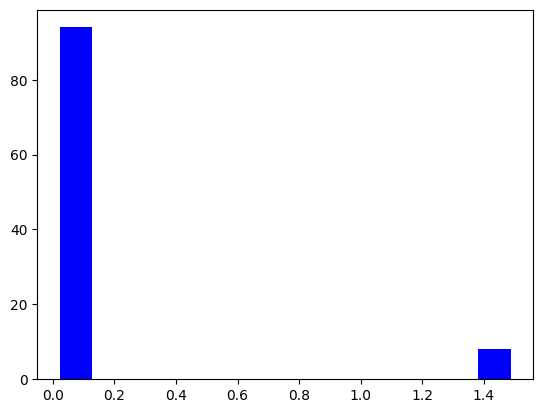

In [61]:
# plot the histogram of the difference
plt.hist(Diff, bins=10, color='blue', rwidth=0.7)

(array([66., 12.,  8.,  0.,  0.,  0.,  0.,  0.,  0.,  4.]),
 array([7.98075126e-08, 2.85581322e-06, 5.63181892e-06, 8.40782462e-06,
        1.11838303e-05, 1.39598360e-05, 1.67358417e-05, 1.95118474e-05,
        2.22878531e-05, 2.50638588e-05, 2.78398646e-05]),
 <BarContainer object of 10 artists>)

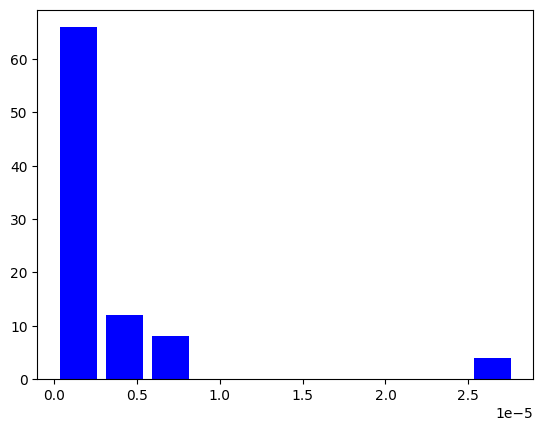

In [63]:
mask = np.array(Diff)<0.0001
Diff_normal = np.array(Diff)[mask]
plt.hist(Diff_normal, bins=10, color='blue', rwidth=0.8)